# Linear Regression Consulting Project

Congratulations! You've been contracted by Hyundai Heavy Industries to help them build a predictive model for some ships. [Hyundai Heavy Industries](http://www.hyundai.eu/en) is one of the world's largest ship manufacturing companies and builds cruise liners.

You've been flown to their headquarters in Ulsan, South Korea to help them give accurate estimates of how many crew members a ship will require.

They are currently building new ships for some customers and want you to create a model and use it to predict how many crew members the ships will need.

Here is what the data looks like so far:

    Description: Measurements of ship size, capacity, crew, and age for 158 cruise
    ships.


    Variables/Columns
    Ship Name     1-20
    Cruise Line   21-40
    Age (as of 2013)   46-48
    Tonnage (1000s of tons)   50-56
    passengers (100s)   58-64
    Length (100s of feet)  66-72
    Cabins  (100s)   74-80
    Passenger Density   82-88
    Crew  (100s)   90-96
    
It is saved in a csv file for you called "cruise_ship_info.csv". Your job is to create a regression model that will help predict how many crew members will be needed for future ships. The client also mentioned that they have found that particular cruise lines will differ in acceptable crew counts, so it is most likely an important feature to include in your analysis! 

Once you've created the model and tested it for a quick check on how well you can expect it to perform, make sure you take a look at why it performs so well!

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('lr_ships').getOrCreate()

In [3]:
df = spark.read.csv("cruise_ship_info.csv", inferSchema=True, header=True)

In [5]:
df.head()

Row(Ship_name='Journey', Cruise_line='Azamara', Age=6, Tonnage=30.276999999999997, passengers=6.94, length=5.94, cabins=3.55, passenger_density=42.64, crew=3.55)

In [7]:
df.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



In [14]:
for col in df.columns:
    print("{1} Null values in {0}".format(col,df.filter(df[col].isNull()).count()))

0 Null values in Ship_name
0 Null values in Cruise_line
0 Null values in Age
0 Null values in Tonnage
0 Null values in passengers
0 Null values in length
0 Null values in cabins
0 Null values in passenger_density
0 Null values in crew


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5c0665f9b0>]],
      dtype=object)

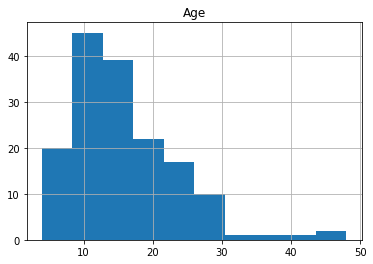

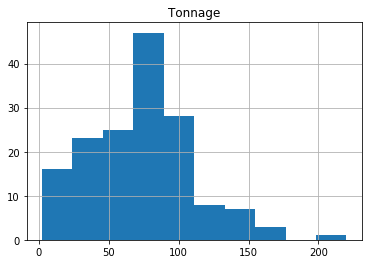

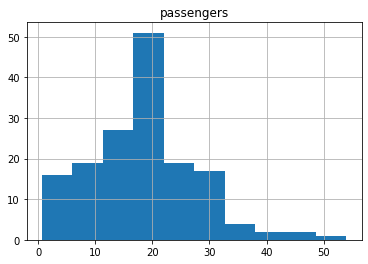

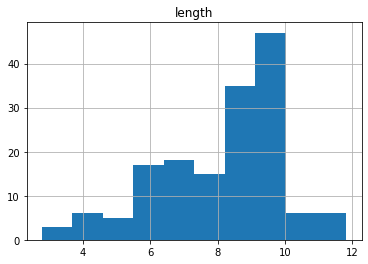

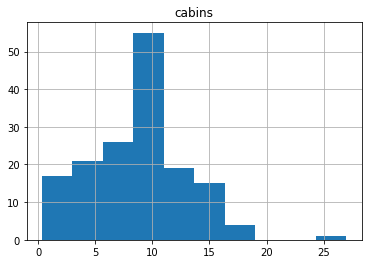

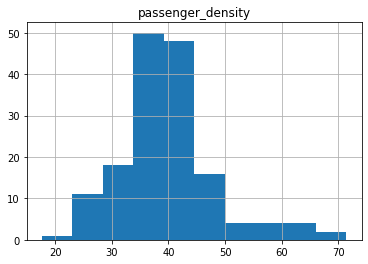

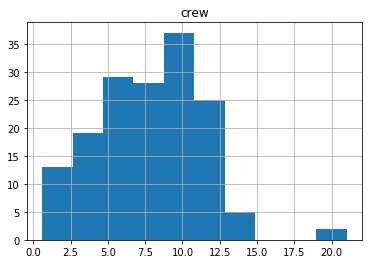

In [35]:
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
df_pandas = df.toPandas()
df_pandas.hist("Age")
df_pandas.hist("Tonnage")
df_pandas.hist("passengers")
df_pandas.hist("length")
df_pandas.hist("cabins")
df_pandas.hist("passenger_density")
df_pandas.hist("crew")



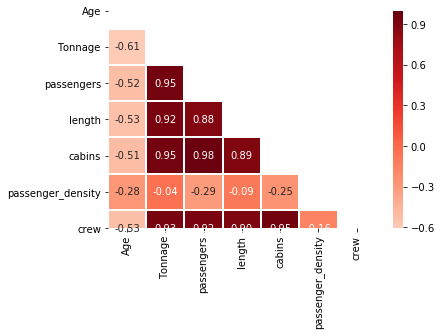

In [99]:
import seaborn as sns
corr = df_pandas.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
# plt.figure(figsize=(10,5))
sns.heatmap(corr, center =0, linewidth=1, annot=True, fmt='.2f', cmap='Reds', mask=mask)

In [52]:
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer

In [77]:
indexer = StringIndexer(inputCol="Cruise_line", outputCol="Cruise_line_cat")
indexed = indexer.fit(df).transform(df)
indexed.groupBy('Cruise_line_cat').count().orderBy('Cruise_line_cat').show()

+---------------+-----+
|Cruise_line_cat|count|
+---------------+-----+
|            0.0|   23|
|            1.0|   22|
|            2.0|   17|
|            3.0|   14|
|            4.0|   13|
|            5.0|   11|
|            6.0|   10|
|            7.0|    8|
|            8.0|    6|
|            9.0|    6|
|           10.0|    5|
|           11.0|    4|
|           12.0|    3|
|           13.0|    3|
|           14.0|    3|
|           15.0|    3|
|           16.0|    2|
|           17.0|    2|
|           18.0|    2|
|           19.0|    1|
+---------------+-----+



In [112]:
assembler = VectorAssembler(inputCols = ['Cruise_line_cat','Age','Tonnage','length','cabins'], outputCol = 'features')

In [113]:
output = assembler.transform(indexed)

In [80]:
output.select("features").show()

+--------------------+
|            features|
+--------------------+
|[16.0,6.0,30.2769...|
|[16.0,6.0,30.2769...|
|[1.0,26.0,47.262,...|
|[1.0,11.0,110.0,9...|
|[1.0,17.0,101.353...|
|[1.0,22.0,70.367,...|
|[1.0,15.0,70.367,...|
|[1.0,23.0,70.367,...|
|[1.0,19.0,70.367,...|
|[1.0,6.0,110.2389...|
|[1.0,10.0,110.0,9...|
|[1.0,28.0,46.052,...|
|[1.0,18.0,70.367,...|
|[1.0,17.0,70.367,...|
|[1.0,11.0,86.0,9....|
|[1.0,8.0,110.0,9....|
|[1.0,9.0,88.5,9.6...|
|[1.0,15.0,70.367,...|
|[1.0,12.0,88.5,9....|
|[1.0,20.0,70.367,...|
+--------------------+
only showing top 20 rows



In [114]:
final_df = output.select(['features','crew'])

In [58]:
final_df.show()

+--------------------+----+
|            features|crew|
+--------------------+----+
|[16.0,6.0,30.2769...|3.55|
|[16.0,6.0,30.2769...|3.55|
|[1.0,26.0,47.262,...| 6.7|
|[1.0,11.0,110.0,9...|19.1|
|[1.0,17.0,101.353...|10.0|
|[1.0,22.0,70.367,...| 9.2|
|[1.0,15.0,70.367,...| 9.2|
|[1.0,23.0,70.367,...| 9.2|
|[1.0,19.0,70.367,...| 9.2|
|[1.0,6.0,110.2389...|11.5|
|[1.0,10.0,110.0,9...|11.6|
|[1.0,28.0,46.052,...| 6.6|
|[1.0,18.0,70.367,...| 9.2|
|[1.0,17.0,70.367,...| 9.2|
|[1.0,11.0,86.0,9....| 9.3|
|[1.0,8.0,110.0,9....|11.6|
|[1.0,9.0,88.5,9.6...|10.3|
|[1.0,15.0,70.367,...| 9.2|
|[1.0,12.0,88.5,9....| 9.3|
|[1.0,20.0,70.367,...| 9.2|
+--------------------+----+
only showing top 20 rows



In [115]:
train_df,test_df = final_df.randomSplit([0.7,0.3])

In [62]:
train_df.describe().show()

+-------+------------------+
|summary|              crew|
+-------+------------------+
|  count|               107|
|   mean| 7.580654205607482|
| stddev|3.3683903190637414|
|    min|              0.59|
|    max|              13.6|
+-------+------------------+



In [63]:
test_df.describe().show()

+-------+------------------+
|summary|              crew|
+-------+------------------+
|  count|                51|
|   mean| 8.242156862745098|
| stddev|3.7664005701600516|
|    min|               1.6|
|    max|              21.0|
+-------+------------------+



In [64]:
from pyspark.ml.regression import LinearRegression

In [116]:
lr = LinearRegression(labelCol = 'crew')

In [117]:
lrModel = lr.fit(train_df)

In [118]:
print('Coefficients: {}, Intercept: {}'.format(lrModel.coefficients,lrModel.intercept))

Coefficients: [0.045347247203460284,-0.012897465776185654,0.004450587940447263,0.3434352947155971,0.6258197826378139], Intercept: -0.8740434179636986


In [119]:
test_results = lrModel.evaluate(test_df)

In [120]:
print("RMSE: {}".format(test_results.rootMeanSquaredError))
print("MSE: {}".format(test_results.meanSquaredError))
print("R2: {}".format(test_results.r2))

RMSE: 0.8699264684220495
MSE: 0.756772060461259
R2: 0.9186737548408473


In [97]:
train_df.describe().show()

+-------+------------------+
|summary|              crew|
+-------+------------------+
|  count|               102|
|   mean| 7.688921568627454|
| stddev|3.3446700341516467|
|    min|              0.59|
|    max|              19.1|
+-------+------------------+

